# DoA Estimation for Wideband Chirps in FrFT Domain #
<p>v1.0 2025</p>

__By__ Eulogio Gutierrez Huampo

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as ss
from numpy import pi,cos,sin,sqrt

import sys
sys.path.append('./src')
import frft_utils as FrFT
import doa_utils as DoA

In [2]:
import ipywidgets as widgets
from IPython.display import display

# Dropdown menu to select mode
mode_selector = widgets.Dropdown(
    options=['dfrft', 'dsmfrft', 'ldsmfrft'],
    value='ldsmfrft',
    description='Operator:',
)

### Signal Modeling

__Time axis__

In [3]:
L_sig = 5e-6 # Duration of signal
N = 1024 # Number of snapshots
fs = N/L_sig # sampling rate
no = N//2 # index of tt=0
tt = np.arange(-no,-no+N)/float(fs) # time axis

__Multi-component linear frequency-modulated (LFM) signal__

In [4]:
fc_list =  np.array([20e6]) # center frequencies
B = 20e6 # bandwidth
mu_list = np.tile(B/L_sig, len(fc_list)) # chirp rates

__Uniform linear array (ULA)__ 

In [5]:
c = 3e8 # light speed, m/s
f2 = np.max(fc_list)+B/2 # highest frequency
lam = c/f2 # wavelength
d = lam/2 # adjacency distance
M = 41 # Number of array elements
mo = M//2 # index of ula=0
ula = d*np.arange(-mo,-mo+M) # ULA

__Received signals__

In [6]:
doa_list = [20]  # True DOAs, degrees
snr = -10 # signal to noise ratio
received_signals = DoA.output_signal_ULA(tt,fc_list,mu_list,ula,
                                         np.radians(doa_list),snr,c)

### Preprocessing

In [7]:
# Display the dropdown and button
display(mode_selector)

Dropdown(description='Operator:', index=2, options=('dfrft', 'dsmfrft', 'ldsmfrft'), value='ldsmfrft')

__Optmal fractional order__

In [8]:
cot_alpha = B/L_sig * N/fs**2 # cot(aOP*pi/2) 
if cot_alpha==0: # Avoid division by zero
    aOP = 1.0
else:    
    aOP = (2/pi)*(pi-np.arctan(1/cot_alpha))    
print(f"Optmal fractional order: {aOP}")

Optmal fractional order: 1.0619733900739727


__Peak indices at reference sensor__

In [9]:
op = mode_selector.value
if op=='dfrft':
    qOP = np.round(fc_list*L_sig*np.sin(aOP*pi/2))   
elif op=='dsmfrft':
    qOP = np.round(fc_list*L_sig)
elif op=='ldsmfrft':
    qOP = np.round(fc_list*L_sig) 
    # Q consecutive points
    aux = fs * d * (1/np.tan(aOP*pi/2)) / c
    s_list = [] # starting point
    Q_list = []
    for m in range(M):
        qmin = int(np.floor(np.min(qOP)-abs((m-mo)*aux)))
        qmax = int(np.ceil(np.max(qOP)+abs((m-mo)*aux)))
        b = np.ceil(np.log2(qmax-qmin+1))
        Q = 2**int(b)    
        s = qmin+N//2
        if s<0:
            s = 0
        if s+Q>N-1:
            s = N-1-Q
        s_list.append(s)
        Q_list.append(Q)    
else:
    raise Warning("Invalid operator!") 
print('Peak indices: ',qOP+N//2)      

Peak indices:  [612.]


__Applying FrFT to each sensor's received signal__

In [10]:
if op=='dfrft':
    frft_signals = np.array([FrFT.dfrft1(tt, signal, aOP) for signal in received_signals])
elif op=='dsmfrft':
    frft_signals = np.array([FrFT.dsmfrft1(tt, signal, aOP) for signal in received_signals])
elif op=='ldsmfrft':
    frft_signals = np.array([[0.0+1j*0.0 for n in range(N)] for m in range(M)]) 
    # Q consecutive points
    for m, signal in enumerate(received_signals):
        s = s_list[m] # starting point
        Q = Q_list[m]
        frft_signals[m,s:s+Q] = FrFT.ldsmfrft(tt, signal, aOP, s-N//2, Q)
else:
    raise Warning("Invalid operator!")

### Multi-target direction-of-arrival (DoA) estimation

__Constrained least square method__

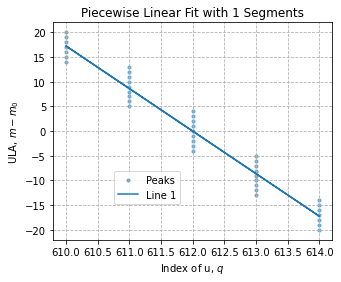

In [11]:
# Example Usage
y, x = DoA.multi_peaks_ULA(tt,frft_signals,ula,aOP,qOP,op,c)
model = DoA.LSM(x, y)
DoA.plot_results_line_fitting(x, y, [model], [(x,y)])

In [12]:
doa_plf_list = []
slope, intercept = model
doa = DoA.doa_line_fitting(fs,d,1.0/slope,aOP,op,c)
doa_plf_list.append(doa*180/pi)
doa_plf = np.sort(doa_plf_list)    
# Display Results
print(f"True DOAs: {doa_list}")
print(f"Estimated DOAs (Line Fitting): {np.round(doa_plf,2)}")    

True DOAs: [20]
Estimated DOAs (Line Fitting): [20.36]


__MUSIC with spatial smoothing and forward-backward averaging__

In [13]:
Lsub = M//2 # size of subarrays
align = True # peak alignment

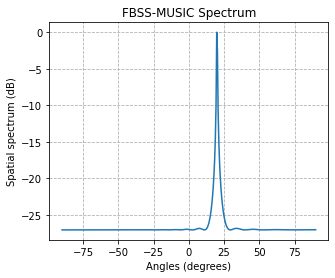

In [14]:
# Estimating DOA using MUSIC and FrFT
i = 0
angles, music_spectrum = DoA.music_frft(tt,frft_signals,mo,qOP,d,aOP,Lsub,i,op,align,c)
music_spectrum_dB = 10 * np.log10(music_spectrum / np.max(music_spectrum))
# Plot MUSIC Spectrum
plt.figure(figsize=(5, 4))
plt.plot(angles, music_spectrum_dB)
plt.title('FBSS-MUSIC Spectrum')
plt.xlabel('Angles (degrees)')
plt.ylabel('Spatial spectrum (dB)')
plt.grid(linestyle= "--") 
plt.show()

In [15]:
# Inices of DOA using MUSIC and FrFT
idxMUSIC,_= ss.find_peaks(music_spectrum_dB ,height=-10.0, distance=1.5)
doa_music = angles[idxMUSIC]
# Display Results
print(f"True DOAs: {doa_list}")
print(f"Estimated DOAs (FBSS-MUSIC): {np.round(doa_music,2)}")

True DOAs: [20]
Estimated DOAs (FBSS-MUSIC): [19.81]


__ESPRIT with spatial smoothing and forward-backward averaging__

In [16]:
# Estimate DOA using ESPRIT with FrFT
estimated_doas = DoA.esprit_frft(tt,frft_signals,mo,qOP,d,aOP,Lsub,op,align,c)
doa_esprit = np.sort(np.degrees(estimated_doas))
# Display Results
print(f"True DOAs: {doa_list}")
print(f"Estimated DOAs (FBSS-ESPRIT): {np.round(doa_esprit,2)}")

True DOAs: [20]
Estimated DOAs (FBSS-ESPRIT): [20.01]
